In [1]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duchu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\duchu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('IMDB-Dataset.csv')

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
# Remove duplicates
df = df.drop_duplicates()

In [5]:
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text) # fixing contractions like "don't" to "do not"

def preprocess_text(text):
    v1 = WordNetLemmatizer()
    soup = BeautifulSoup(text, "html.parser") # removing html tags
    text = soup.get_text()
    text = expand_contractions(text) # expanding contractions like
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text) # removing emojis
    text = re.sub(r'\.(?=\S)', '. ', text) # adding space after full stop
    text = re.sub(r'http\S+', '', text) # removing urls
    text = ''.join([word.lower() for word in text if word not in string.punctuation]) # removing punctuations and converting to lower case
    text = ' '.join([v1.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # removing stopwords and lemmatizing
    return text

df['review'] = df['review'].apply(preprocess_text)


C:\Users\duchu\AppData\Local\Temp\ipykernel_3712\2047886702.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") # removing html tags
C:\Users\duchu\AppData\Local\Temp\ipykernel_3712\2047886702.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(preprocess_text)


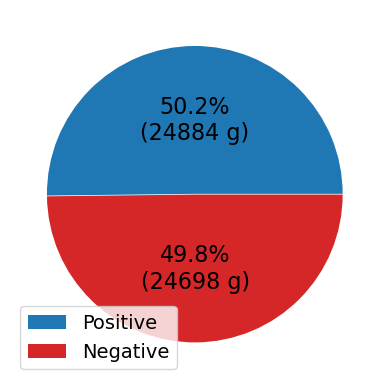

In [9]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['Positive', 'Negative']

# Create pie chart
pie, ax = plt.subplots()
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
plt.legend(labels, loc="best", prop={'size': 14})
# pie.savefig("PieChart.png")
plt.show()

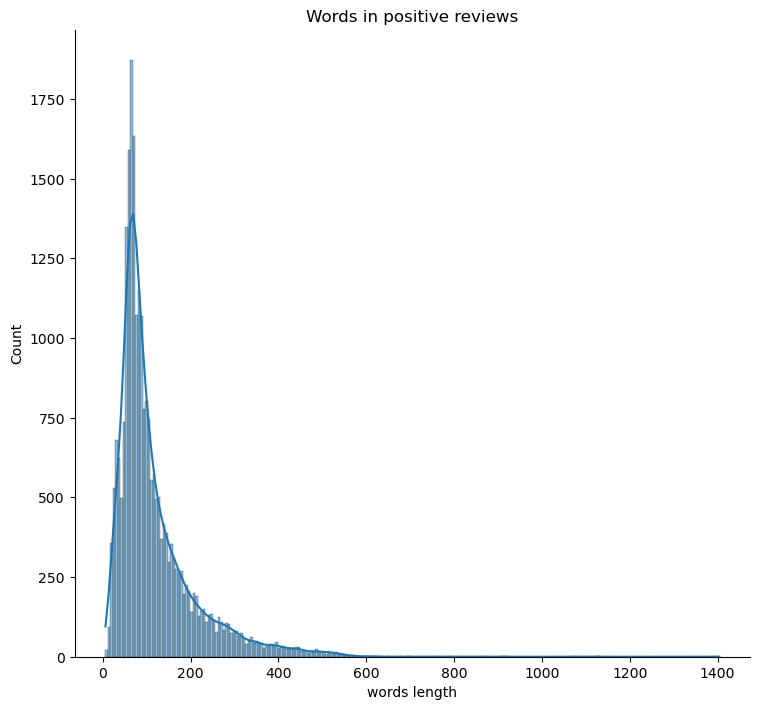

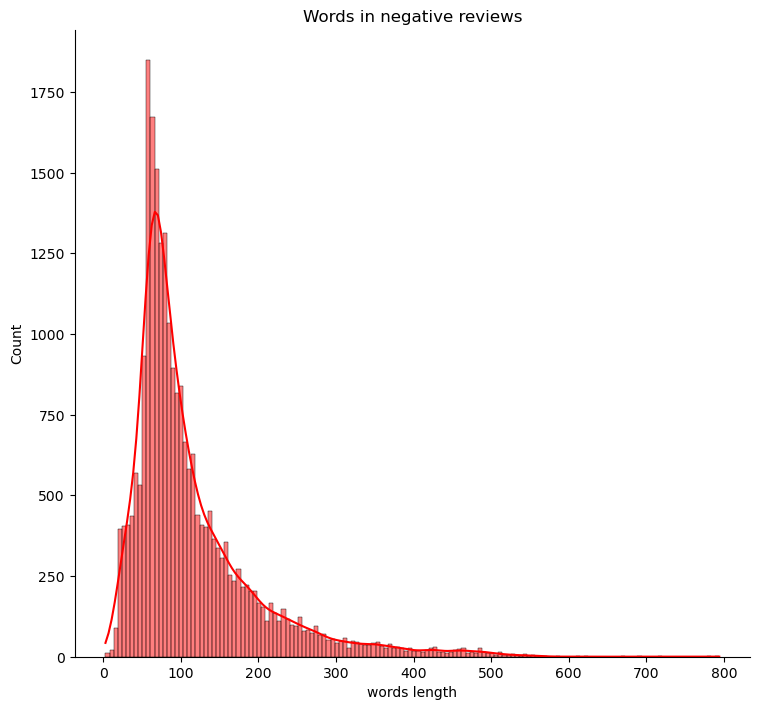

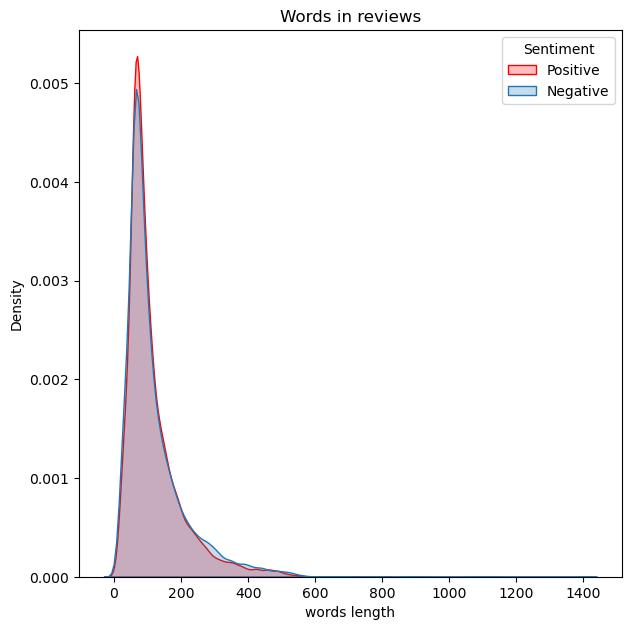

In [12]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'positive'],
    x = 'words length',
    hue='sentiment',
    height=7,
    aspect=1.1,
    legend=False,
    kde=True
).set(title='Words in positive reviews')

plt.show(hist_positive)

hist_negative = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'negative'],
    x = 'words length',
    hue='sentiment',
    height=7,
    aspect=1.1,
    legend=False,
    kde=True,
    palette=['red']
).set(title='Words in negative reviews')

plt.figure(figsize=(7, 7.1))
kernel_distibution_number_words_plot = sns.kdeplot(
    data=df_temp,
    x='words length',
    hue='sentiment',
    fill=True,
    palette=[sns.color_palette()[0], 'red'],
).set(title='Words in reviews')

plt.legend(title='Sentiment', loc='upper right', labels=['Positive', 'Negative'])
plt.show(kernel_distibution_number_words_plot)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x_data = df['review']
y_data = label_encoder.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

In [16]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7140264192800242

In [18]:
rf_classifier = RandomForestClassifier(
    random_state=42
)

rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8485429061208026